In [3]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import pandas as pd
import emcee
import corner

# S11 and Freq Values

In [2]:
#Loading S11(RLC) and Frequency values
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/Users/gopipatel/Documents/RRI_VSP/saras3_S11_200mm_above_water.s1p", skiprows=5))
d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
v=[d[i][0] for i in range(len(d)-1)]


df=pd.read_csv('/Users/gopipatel/Downloads/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()
print(rlc)
plt.plot(v,rlc)
plt.xlabel('Freq')
plt.ylabel('S11')

FileNotFoundError: /Users/gopipatel/Documents/RRI_VSP/saras3_S11_200mm_above_water.s1p not found.

# Model Fitting S11 Values

[-6.33239601e-48  2.67055112e-39 -4.55857647e-31  4.17703002e-23
 -2.18616518e-15  5.07417317e-08  4.73256120e-01]
2.097528500095385e-16


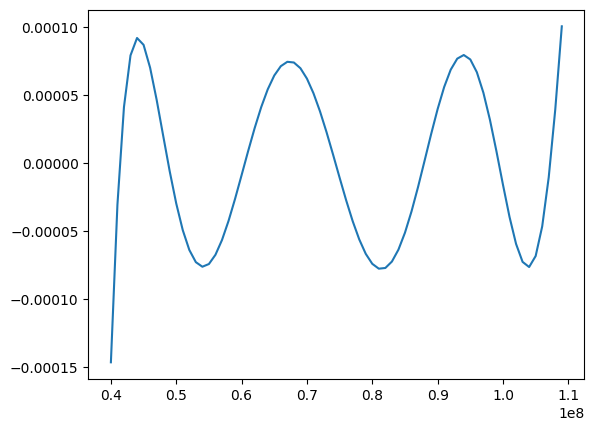

In [4]:
fit=np.polyfit(v,rlc,6)
print(fit)
p0,p1,p2,p3,p4,p5,p6=fit
model= np.polyval(fit,v)
res=model-rlc
#plt.plot(v,model)
#plt.plot(v,rlc)
plt.plot(v,res)
print(st.mean(res))

Text(0, 0.5, 'S11')

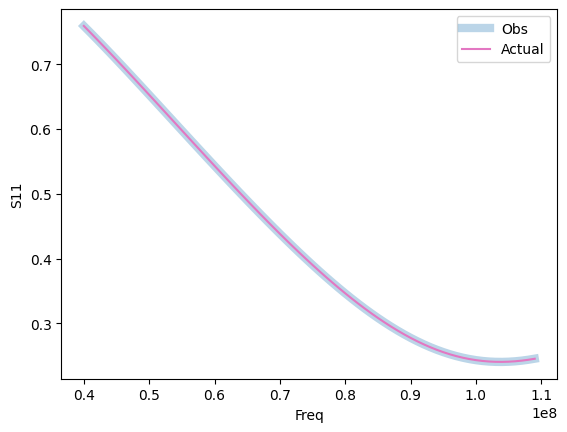

In [138]:
#Reconstructed
po,p1,p2,p3,p4,p5,p6=[-6.33239601e-48,  2.67055112e-39, -4.55857647e-31,  4.17703002e-23,
 -2.18616518e-15,  5.07417317e-08,  4.73256120e-01]
#[-6.274954869166671, 2.716009717976181, -4.6891133131425535, 4.149936149195398, -2.270563185191849, 4.867143968582065, 4.753308867794712]
#p6,p5,p4,p3,p2,p1,p0=
N=7

gamma_rlc=[]
for i in range(len(v)):
    gamma_value = (p0 * v[i] ** (N - 1) + 
                   p1 * v[i] ** (N - 2) + 
                   p2 * v[i] ** (N - 3) + 
                   p3 * v[i] ** (N - 4) + 
                   p4 * v[i] ** (N - 5) + 
                   p5 * v[i] ** (N - 6) + 
                   p6)
    gamma_rlc.append(gamma_value) 
plt.plot(v,gamma_rlc,alpha=0.3, lw=6, label='Obs')
plt.plot(v,rlc,'tab:pink',label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
#plt.plot(v,rlc)

# Computing Tmeas

In [114]:
def Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    freq= [d[i][0] for i in range(len(d))]
    for i in range(len(v)):
        gamma_A=p0*1e-48* freq[i] ** (N - 1) + p1*1e-39* freq[i] ** (N - 2) + p2*1e-31* freq[i] ** (N - 3) + p3*1e-23* freq[i] ** (N - 4) + p4*1e-15* freq[i] ** (N - 5) + p5*1e-08* freq[i] ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

70
70


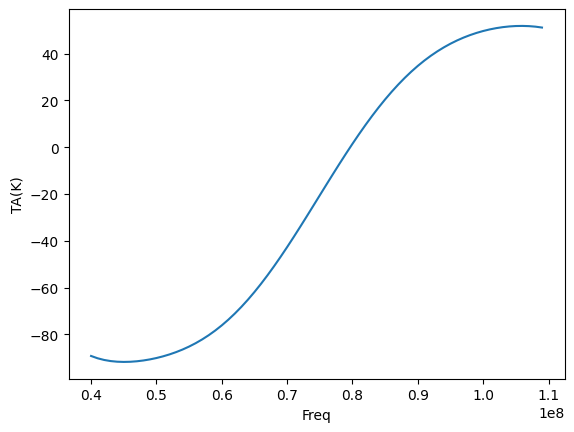

In [127]:
TA=Compute_Tmeas_(300,-6.33239601,  2.67055112, -4.55857647,  4.17703002,
 -2.18616518,  5.07417317,  4.73256120, 70, 0.3, 0.1, 1)
plt.plot(v,TA)
plt.xlabel('Freq')
plt.ylabel('TA(K)')
print(len(TA))
print(len(v))


# MCMC for RLC Coefficients

In [116]:
def evolve_MCMC_RLC(ip_params,nsteps, initial_value):# Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
    
    PA=300 
    p0, p1, p2, p3, p4, p5, p6 = ip_params
    PN=70
    gamma_N=0.3
    f=0.1 
    l = 1
    
    # Define bounds for parameters
    min_values = [ -6,  1, -5,  3.8, -2.5,  4.5,  4]
    #if type=='open' or type=='short':
    max_values= [-5,  3, -4,  4.8, -1.8,  5.5,  5] 
    
    
    #freq= [d[i][0] for i in range(len(d))]
    
    # Define the Expected TA values
    np.random.seed(38)
    TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    ########## Define the log-likelihood function
    def log_likelihood(params):
        PA=300 
        p0, p1, p2, p3, p4, p5, p6 = params
        PN=70
        gamma_N=0.3
        f=0.1 
        l = 1
    
        # Compute model TA
        TA_model = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) #+ np.random.normal(0,0.001,len(v))
        TA_model=np.array(TA_model)

        # Compute chi-squared with weights
        s = 0.001  # Uncertainty
        chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 
    
        return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s) # Likelihood function
    
    ########## Define the log-prior function
    def log_prior(params):
        
        PA=300 
        p0, p1, p2, p3, p4, p5, p6 = params
        PN=70
        gamma_N=0.3
        f=0.1 
        l = 1
        """
        # Check if params are within bounds
        if 0.0 < PA < 5 and 0.0 < gamma_A < 1.0 and 5.0 < PN < 100.0 and 0.0 < gamma_N < 1.0 and 0.05 < f < 0.9 and 0.1 < l < 1.0:
            return 0.0
        return -np.inf
        """
    
        
        #for p, min_v, max_v in zip(params, min_values, max_values):
            #if not (min_v <= p <= max_v):
                #return -np.inf  # Reject sample
        return 0.0  # Uniform prior
        
    
    ######### Define the full log-probability function
    
    def log_probability(params):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)
    
    # Number of walkers and steps
    ndim = 7  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ############### Initialize walkers around a random point in parameter space
    
    #initial = np.array([np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)])
    
    #initial = np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)])
    initial_value=initial_value
    
    ########## Starting positions for the walkers
    #pos = initial 
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(pm,(1+1e-1)*pm) for pm in inp_params] for _ in range(nwalkers)])
    pos= initial_value + 1e-2*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    #ind_pos = pos<0
    #pos[ind_pos] = np.abs(1e-1*np.random.randn(nwalkers, ndim))
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 
    
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [140]:
#evolve MCMC for RLC parameters
ip_params=[-6.33,  2.67, -4.56,  4.17,-2.186,  5.07,  4.73]
#initials=result.x #input parameters
initials=[-6,  2.4, -4.1,  4.0, -1.96,  4.7,  4.5] #p00#[0.0008,1.0,70.07,0.2990,0.0998,0.999]
#chains=3
nsteps=3000

full_samples, samples, best_fit_params= evolve_MCMC_RLC(ip_params,nsteps=nsteps, initial_value=initials)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [05:01<00:00,  9.97it/s]


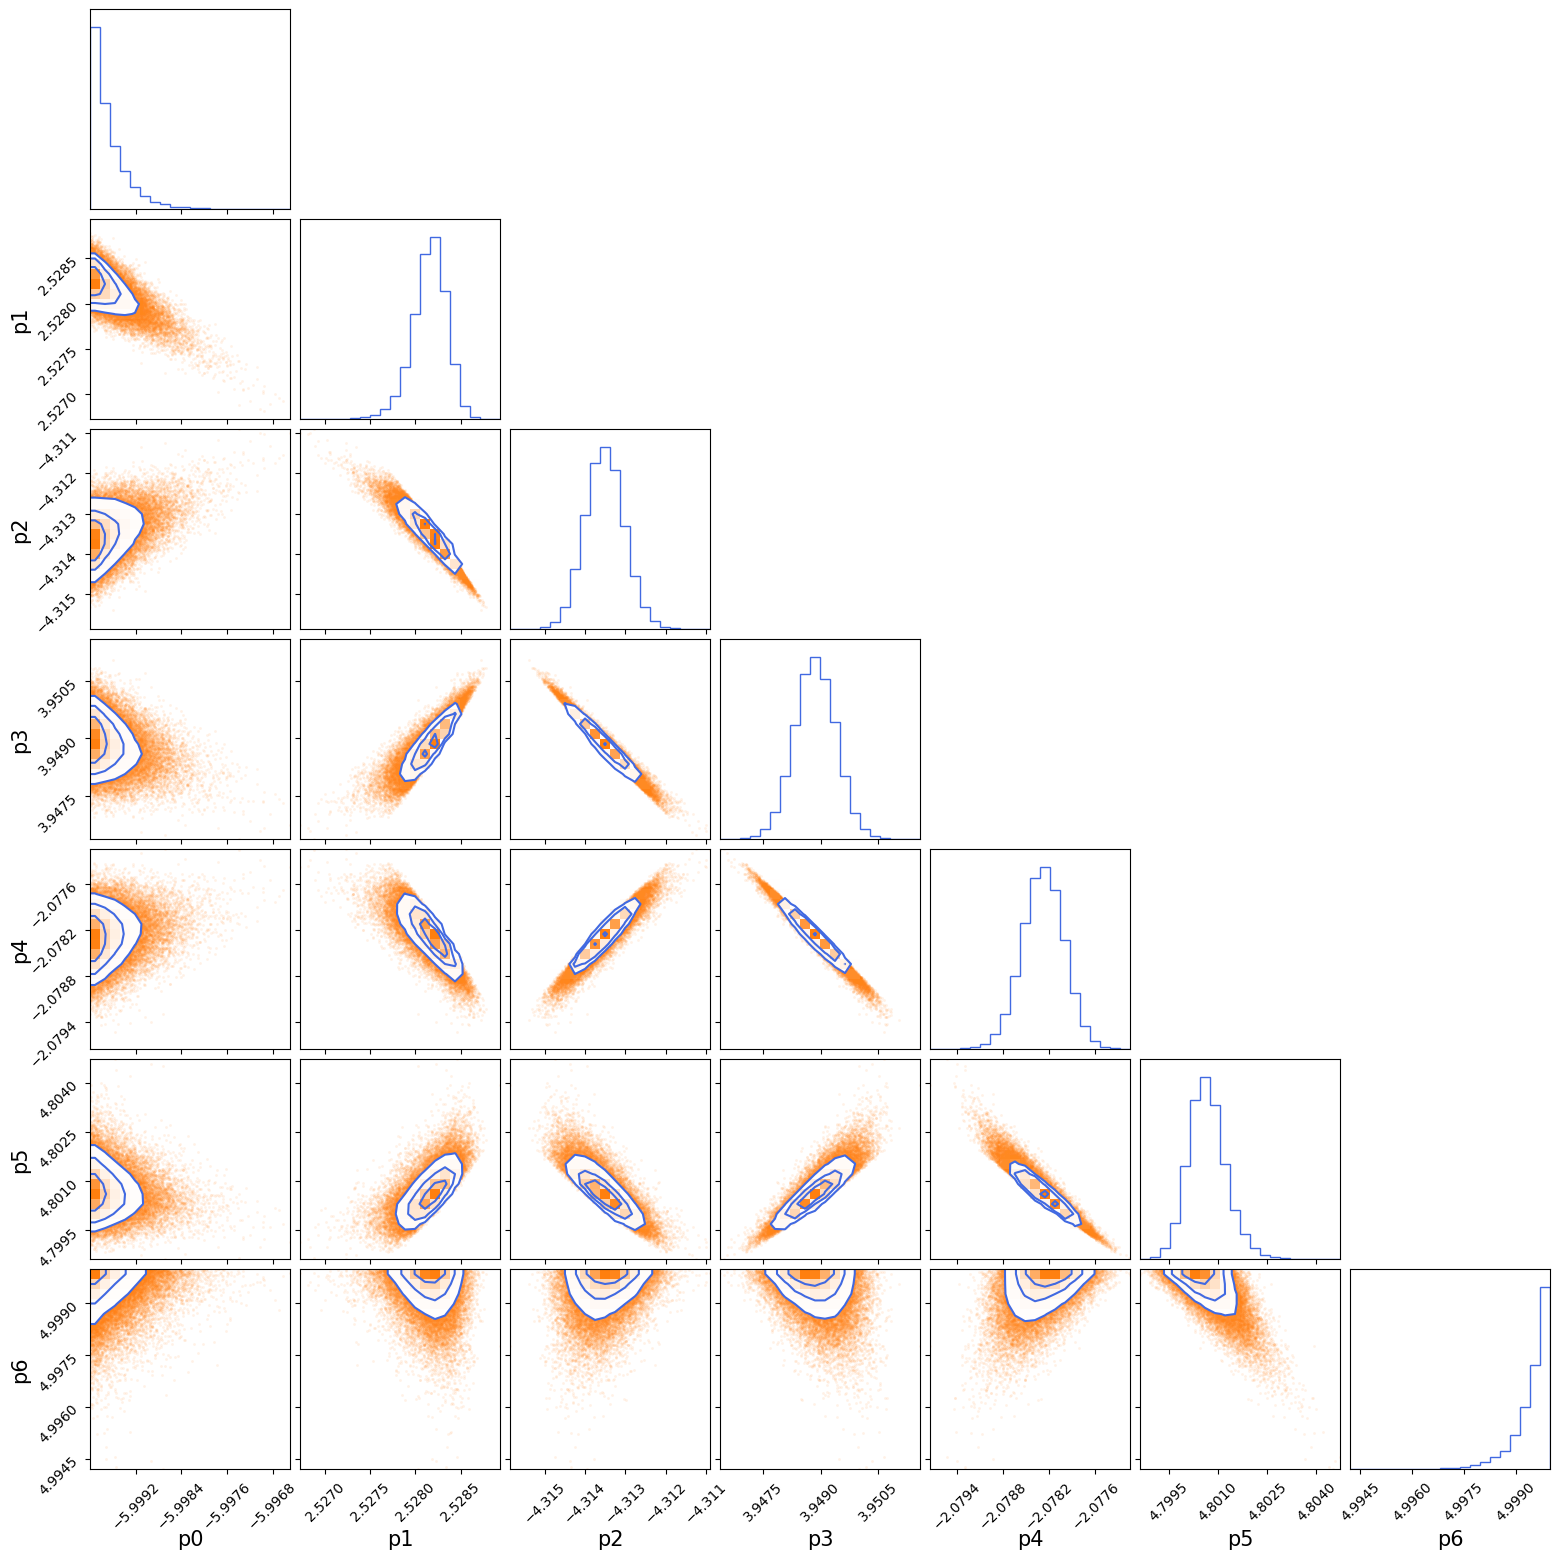

Best-fit parameters (Maximum Likelihood Estimate): [-5.999989135862608, 2.528233145684688, -4.313558885617888, 3.9487951858533448, -2.078206555118119, 4.800363165962916, 4.9999163027896705]


In [141]:
parameter_names = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
#plt.savefig('/Users/gopipatel/Desktop/RLC_1m.png', dpi=300)
#plt.savefig('Art.png')
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params)

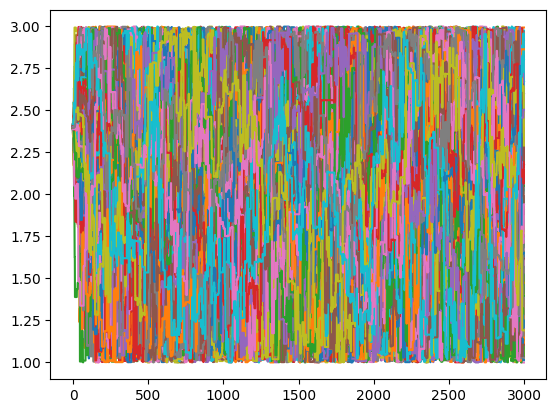

In [90]:
#samples.shape
plt.plot(full_samples[:,:,1])
plt.show()

# Full MCMC

In [143]:
#full MCMC
def evolve_MCMC_Full(ip_params,nsteps, initial_value):# Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
    
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
        
    # Define bounds for parameters
    min_values = [0, -7,  1, -5,  3.5, -3.2,  4.5,  4, 50.0, 0.0, 0.05,0.05]
    max_values = [500, -5,  3, -4,  4.8, -1.8,  5.5,  5, 150, 1, 0.5, 5] #maximum value of mass being scanned for load terminal
    
    #freq= [d[i][0] for i in range(len(d))]
    
    # Define the Expected TA values
    
    TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    ########## Define the log-likelihood function
    def log_likelihood(params):
        PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    
        # Compute model TA
        TA_model = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)# + np.random.normal(0,0.001,len(v))
        TA_model=np.array(TA_model)

        # Compute chi-squared with weights
        s = 0.001  # Uncertainty
        chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 
    
        return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s) # Likelihood function
    
    ########## Define the log-prior function
    def log_prior(params):
        
        PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
        """
        # Check if params are within bounds
        if 0.0 < PA < 5 and 0.0 < gamma_A < 1.0 and 5.0 < PN < 100.0 and 0.0 < gamma_N < 1.0 and 0.05 < f < 0.9 and 0.1 < l < 1.0:
            return 0.0
        return -np.inf
        """
    
        
        #for p, min_v, max_v in zip(params, min_values, max_values):
            #if not (min_v <= p <= max_v):
                #return -np.inf  # Reject sample
        return 0.0  # Uniform prior
        
    
    ######### Define the full log-probability function
    
    def log_probability(params):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)
    
    # Number of walkers and steps
    ndim = 12  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ############### Initialize walkers around a random point in parameter space
    
    #initial = np.array([np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)])
    
    #initial = np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)])
    initial_value=initial_value
    
    ########## Starting positions for the walkers
    #pos = initial 
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(pm,(1+1e-1)*pm) for pm in inp_params] for _ in range(nwalkers)])
    pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    #ind_pos = pos<0
    #pos[ind_pos] = np.abs(1e-1*np.random.randn(nwalkers, ndim))
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 
    
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, thin=10, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [144]:
#evolve MCMC full
ip_params=[300,-6.33239601,  2.67055112, -4.55857647,  4.17703002,
 -2.18616518,  5.07417317,  4.73256120,70, 0.3, 0.1, 1]
#initials=result.x #input parameters

#p0, p1, p2, p3, p4, p5, p6= best_fit_params#[300,-6.33239601e-49,  2.67055112e-40, -4.55857647e-32,  4.17703002e-24, -2.18616518e-16,  5.07417317e-09,  4.73256120e-02, 70.0, 0.3, 0.1, 1] #p00#[0.0008,1.0,70.07,0.2990,0.0998,0.999]
initials=[300,-6.38730307997496, 2.7891640902076955, -4.67143059386103, 4.134099066598428, -2.192789915720878, 4.951463099669312, 4.704836536063398, 70.1, 0.29, 0.099, 0.9]
#[300,-6.274954869166671, 2.716009717976181, -4.6891133131425535, 4.149936149195398, -2.270563185191849, 4.867143968582065, 4.753308867794712, 70.1, 0.29, 0.099, 1.9]
#[300, p0, p1, p2, p3, p4, p5, p6, 70.1, 0.29, 0.099, 0.9]


nsteps=3000

full_samples, samples, best_fit_params= evolve_MCMC_Full(ip_params,nsteps=nsteps, initial_value=initials)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [06:18<00:00,  7.92it/s]


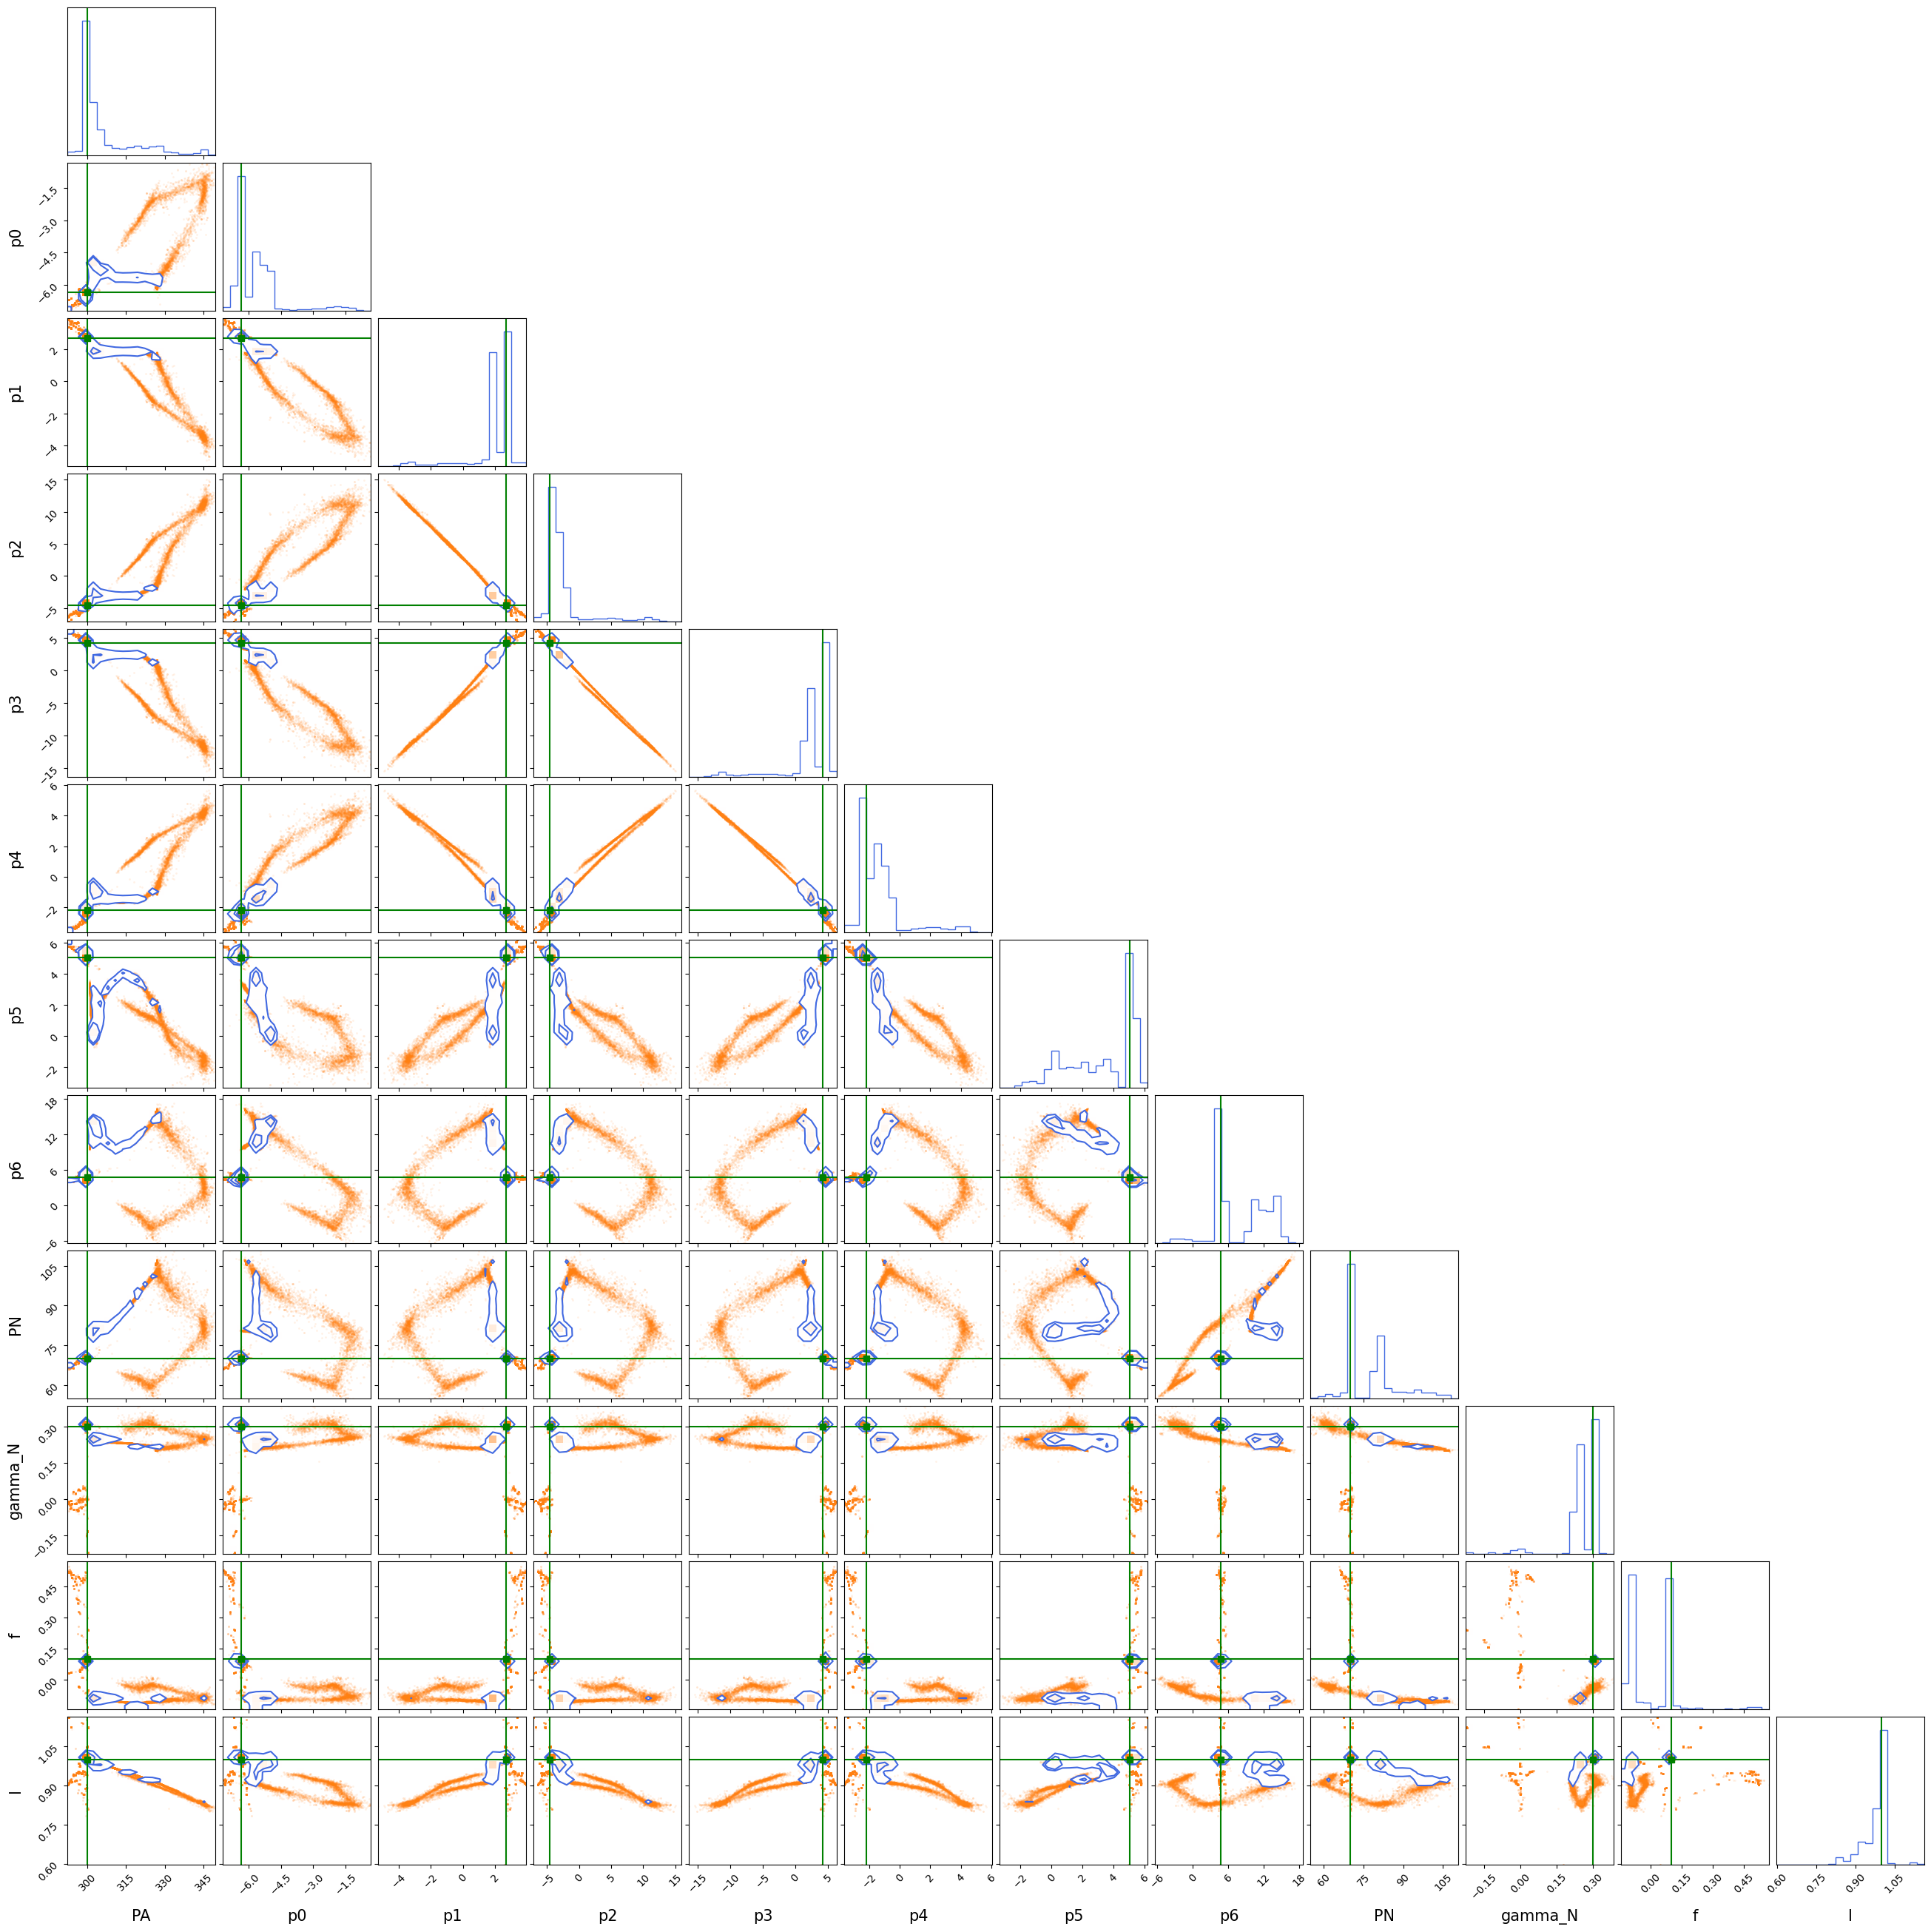

Expected Parameters: [300, -6.33239601, 2.67055112, -4.55857647, 4.17703002, -2.18616518, 5.07417317, 4.7325612, 70, 0.3, 0.1, 1]
Best-fit parameters (Maximum Likelihood Estimate): [299.88949804128356, -6.398427577573315, 2.7126524002533055, -4.659355729488636, 4.295044663017882, -2.259045860268372, 5.317609287047352, 4.288255271345146, 70.41653871696467, 0.30379597052208485, 0.09958246857332738, 1.0003431487749572]


In [145]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
#plt.savefig('/Users/gopipatel/Desktop/RLC_full__1m.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Expected Parameters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params)

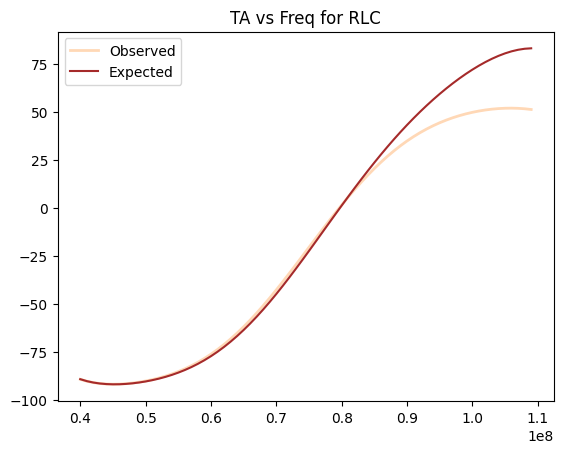

In [135]:
#PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = best_fit_params
Ta=Compute_Tmeas_(*best_fit_params)
ip_params=[300,-6.33,  2.67, -4.56,  4.2, -2.2,  5.1,  4.7, 70, 0.3, 0.1, 1]
TA=Compute_Tmeas_(*ip_params)
plt.plot(v,Ta,label='Observed', color='C1',alpha=0.3, lw=2)
plt.plot(v,TA,label='Expected', color='brown')
plt.legend()
plt.title('TA vs Freq for RLC')
plt.savefig('/Users/gopipatel/Desktop/Comparision_plot_2m.png', dpi=300)

Text(0, 0.5, 'S11')

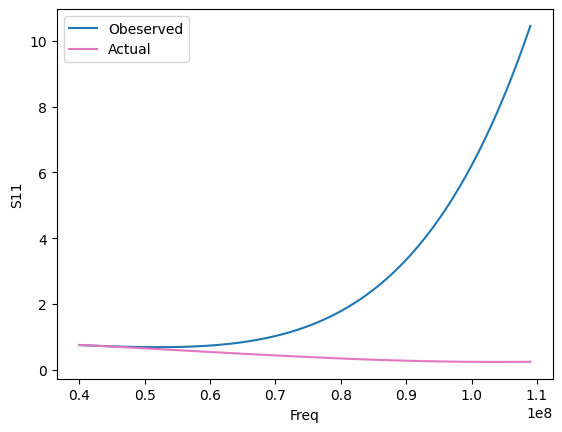

In [142]:
#Reconstructed
po,p1,p2,p3,p4,p5,p6=[ -6.430041004115615, 2.7528192300860463, -4.682182831765962, 4.183682540583748, -2.183929863092387, 5.035546799436044, 4.704620693322314]
#[-6.274954869166671, 2.716009717976181, -4.6891133131425535, 4.149936149195398, -2.270563185191849, 4.867143968582065, 4.753308867794712]
#p6,p5,p4,p3,p2,p1,p0=
N=7

gamma_rlc=[]
for i in range(len(v)):
    gamma_value = (p0 *1e-48* v[i] ** (N - 1) + 
                   p1 *1e-39* v[i] ** (N - 2) + 
                   p2 *1e-31* v[i] ** (N - 3) + 
                   p3 *1e-23* v[i] ** (N - 4) + 
                   p4 *1e-15* v[i] ** (N - 5) + 
                   p5 *1e-08* v[i] ** (N - 6) + 
                   p6*1e-01)
    gamma_rlc.append(gamma_value) 
plt.plot(v,gamma_rlc, label='Obeserved')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')